# Visualizing Bay Wheels
**Authoer**: Tim Chen, chentim@berkeley.edu

## Introduction  
[Bay Wheels](https://www.lyft.com/bikes/bay-wheels) is a bike rental service of Lyft in the San Francisco Bay Area. The goal of the study is to help the company **increase "commuter" ridership** by developing **promotional marketing strategies** based on data analytics. The analysis consists of three stages: The concept of a "commuter trip" is first defined. Data analytics are then performed using BigQuery on GCP. Lastly, a total of three promotional marketing strategies are proposed based on the data to increase Bay Wheels' ridership.  

<p align="center"><img src="https://www.dropbox.com/s/bnnkn0nespjh5p3/workflow.png?dl=1" width="620" /></p>

## Datasets
The two datasets, `Bikeshare Trips` and `Bikeshare Stations`, from Bay Wheels are hosted on GCP (Google Cloud Platform) through BigQuery. `Bikeshare Trips` includes a total of **983,648 rental bike trips** over 3 years **from 2013 to 2016**. `Bikeshare Stations`, as a complementary dataset, includes **specifications of the stations** (e.g. GPS coordinates, scales, creation/retire dates, etc.) that are owned by Bay Wheels during the same timespan.  

## Notebook Setup

In [1]:
# data libraries
import pandas as pd
import numpy as np
from google.cloud import bigquery
from collections import namedtuple

# plot libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# NOT REQUIRED for running the notebook on GCP!
# import os
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "gcp_auth_key.json"

# general style configs
%matplotlib inline
sns.set() # use Seaborn styles
plt.style.use(u"bmh") # https://tinyurl.com/y8zmrmkb

# general plot configs
FIG = namedtuple("FIG", ())
FIG.FONT_SIZE = 12
FIG.TITLE_FONT_SIZE = 15
FIG.TITLE_LINESPACE = 0.9
FIG.FONT_SIZE_LEGEND = 14
FIG.W = 15
FIG.H = 5

## Concept Definition: Commuter Trip

### Defining the Commuter Trip
The analysis adopts a broader definition of "commute" that can be best characterized in two parts:

- The first part of the definition is best summarized by a description from Wikipedia:  
  
  _"Commuting is periodically **recurring** travel between one's place of residence and place of work, study, or other **routines**, and in doing so **exceed** the boundary of their residential community."_   
  
  The three keywords are "recurring," "exceeding," and "routines." Instead of focusing on just analyzing the trips between home and work, the analysis attempts to entail all recurring trips people take outside of their homes. The trips can take place not only for work, but also routines including but not limited to school, shopping, or even a personal favorite hiking trail.

- In addition, more than one trip can occur between a commuter's "true" starting and ending points, including the use of multiple bikes or even other forms of transportations such as a ferry. For example, a typical commuter trip might be as follow:
  
    - Start the trip from home in a suburban area such as Berkeley;
    - Take bus to the ferry terminal;
    - Take ferry to San Fransisco;
    - Bike from the ferry terminal to a Starbucks for breakfast;
    - Bike again to a station nearby his/her destination; and finally,
    - Complete the trip by walking to the true ending point, which may or may not be a workplace.  
  
  Note that under the definition, a single commuter trip can include more than one trips using bikes. Also note that the final destination does not need to be a workplace. A student's recurring destination can be a school, a patient's recurring destination can be a hospital, an athlete's recurring destination can be different training grounds across a particular suburban area, etc.
  
The two definitions above have a few important implications on the way we aggregate data:
- A commuter trip does not need to be a round trip between home and destination. A white collar worker, for example, might ride a bike to work but prefer taking bus or Uber home after a long tiring day.
- A commuter trip does not need to happen during the "normal hours" (say, from 7am to 7pm). A student, for example, might have late evening classes or club activities. 
- A commuter trip can take place on weekends. For example, an athlete's regular trips can happen frequently during weekends, especially when closer to the game day. 
  
### Definition Justification
The goal is to increase ridership. A narrow definition such as "commuter trips are the trips people take between home and workplace" could exclude a large segment of untapped market. 

The decision to adopt a broad definition is also justified by the various data points from Part II. For example, while most people don't live nearby their workplaces, nearly all bike trips take place within the same "area" (i.e. San Francisco, San Jose, Mountain View, Palo Alto, and Redwood City). In particular, over 90% of the trips take place in San Francisco, most of which start or end with the ferry terminals. The data clearly indicates that bikes are used ONLY as a part of the trip between our customers' true starting and ending points. Data also show that a significant number of trips take place in weekends, which should not be excluded from the analysis.

### Top 5 Commuter Trips
The top 5 most popular commuter trips according to the definitions above are summarized by the table below.

In [2]:
client = bigquery.Client()
sql = """
SELECT  
  start_landmark AS area,
  start_station_name,
  end_station_name,
  COUNT(*) AS trip_count,
  ROUND(AVG(duration_sec)/60, 2) AS avg_duration_mins
FROM
  `fluted-bee-273018.w205_proj_1.trips_plus_landmark`
WHERE
  -- exclude inter-landmark trips
  start_landmark = end_landmark
GROUP BY 
  start_station_name,
  end_station_name,
  start_landmark
ORDER BY
  trip_count DESC
LIMIT 5
"""
df = client.query(sql).to_dataframe()
df.index = [1, 2, 3, 4, 5]
pd.set_option("display.precision", 2)
print('Top 5 Commuter Trips:')
df.rename(columns={'area': 'Area',
                   'start_station_name': 'Starting Station',
                   'end_station_name': 'Ending Station',
                   'trip_count': 'Number of Trips',
                   'avg_duration_mins': 'Avg. Trip Duration'}, inplace=True)
display(df)

Top 5 Commuter Trips:


,Area,Starting Station,Ending Station,Number of Trips,Avg. Trip Duration
1,San Francisco,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,9150,19.80
2,San Francisco,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,8508,5.11
3,San Francisco,2nd at Townsend,Harry Bridges Plaza (Ferry Building),7620,9.70
4,San Francisco,Harry Bridges Plaza (Ferry Building),2nd at Townsend,6888,10.63
5,San Francisco,Embarcadero at Sansome,Steuart at Market,6874,8.52


## Recommendation: Promotional Strategies to Increase Commuter Trips  
Bay Wheels currently offers three categories of offers:  

| Single Use |  Membership | Trial |
| ----- | ----- | ----- |
| Single Ride  | Monthly Membership  | Bike Share for All |
| Access Pass  | Annual Membership   | |  
    
As our goal is to increase ridership with a focus on tackling the commuter trips (i.e. repeated trips), the promotion strategy will be primarily based on two specific phases of the marketing funnel:
- **Acquisition**: Acquire new customers
- **Loyalty**: Drive the ridership of our existing customers
 
Note that a commuter can be either a subscriber or non-subscriber based on our definition.  

### Recommendation Summary  
In summary, we recommend three promotional strategies: 
- Build subscriber referrals and local partnership programs.
- Create new pricing models for routine commuters and low-traffic hours/months.
- Take advantage of great stories from "inter-area" bikers.

### Recommendation I: Build Subscriber Referrals & Local Partnership Programs
#### Promotion Design
- **Referrals:** 
    - Target Audience: 
        - Subscribers
    - Strategy: 
        - Create incentives for existing members to make referrals. 
    - Operational Details:
        - Given the audience (i.e. existing subscribers who are already using Bay Wheels' bikes for commuting), the focus should be promoting the "practical" benefits of biking, including but not limited to convenience and health benefits as an alternative form of transportation.
        - In addition, we should emphasize the fact that most commuters use our bikes ONLY for a portion of their daily commute averaging less than 10 minutes. Drive or take the Ferry to downtown as you have already been doing, but ride a Bay Wheels' bike for the last 10 minutes of your trip! The option is at an affordable price with all the additional benefits such as convenience and a healthier lifestyle you can start enjoying today!
        - An example of the actual execution could be a new iOS/Android app feature that allows the members to easily make referrals and communicate the benefits of biking. As an incentive, we can also consider offering monetary rewards such as an additional month of free membership for each successful referral. 
- **Local Partnership:**
    - Target Audience: 
        - Non-Subscribers
    - Strategy: 
        - Promote the "fun experience" with Bay Wheels by partnering with local hotels and stores/service providers in popular tourist attractions. 
    - Operational Details:
        - It makes little sense to even try converting most of our existing non-subscribers to become members, as explained by the justifications below.
        - Instead, we should focus on showing these tourists or short-term customers the fun they can have by using a Bay Wheels' bike in Union Square or along the coastline.
        - An example of the actual execution could be a new B2B web page at Lyft.com that allows potential partners to learn more about and sign up for the partnership program. In addition, we can consider commission based sales that would monetarily reward our partners by promoting the Bay Wheels experience.
        - Bonus: The trip duration for non-subscribers at 90th percentile is 2+ hours while the median is only 18 minutes. We believe that the current pricing model described at Lyft.com is overly complicated and does NOT encourage longer rides. Tourists should be less price sensitive comparing to local commuters because they are visiting for a fun experience rather than saving money. Consider removing the incremental pricing structure and instead offer a simple hourly rate.

#### Justifications
One of the two goals for our promotion is new customer acquisition. Intuitively, it makes logical sense to start by converting as many of our existing non-subscribing customers as possible to become our long-term members. Data, however, speak otherwise and show strong indications that:
- Non-subscribers are fundamentally different from those who subscribe to Bay Wheels' membership. 
- A large number of our non-subscribers are tourists who have little incentive to subscribe due to their short-term stay in the area.

For example, popular trips by non-subscribers tend to start at tourist attractions such as Union Square and Water Historical District while subscribers tend to bike between ferry terminals and the San Francisco downtown area. In addition, the median duration for trips in San Francisco (which account for roughly 90% of the trips for both subscribers and non-subscribers) is 18.28 minutes for non-subscribers, more than double of subscribers' median at 8.18 minutes. Data clearly show that non-subscribers use Bay Wheels' bikes mostly for touring and enjoy their time visiting the area while subscribers mostly focus on commuting from point A to point B as quickly as possible. 

Given the fundamental difference in behaviors between non-subscribers and subscribers, it makes little sense to even try convincing non-subscribers to sign up for Bay Wheels' long-term members. Why would a tourist who is temporarily visiting the area have any incentive to sign up for a long-term subscription that is only locally valid? Instead, a better strategy for new customer acquisition should be applying different treatments to the two fundamentally different groups.

#### Supporting Data

##### Trip Popularity by Geographical Area
San Francisco accounts for roughly 90% of the trips for both subscribers and non-subscribers. This is the area where the analysis will focus on.

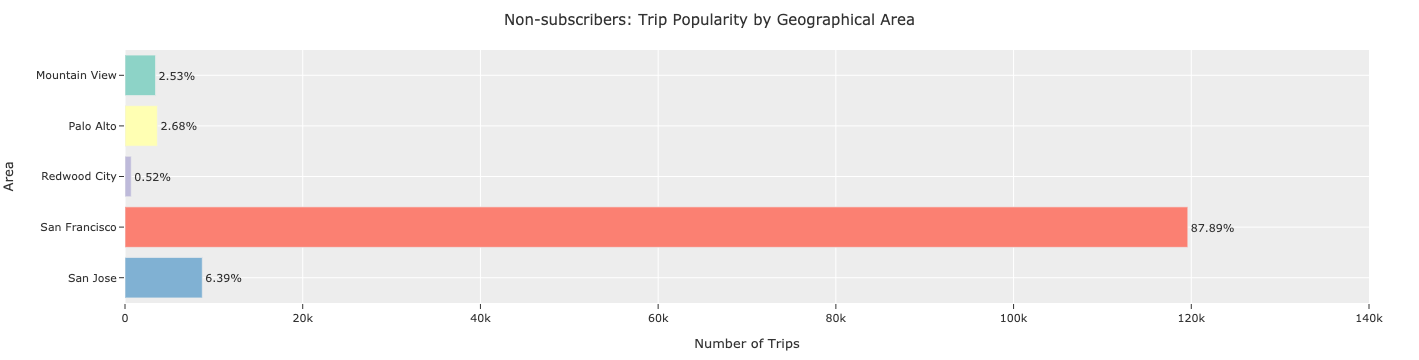

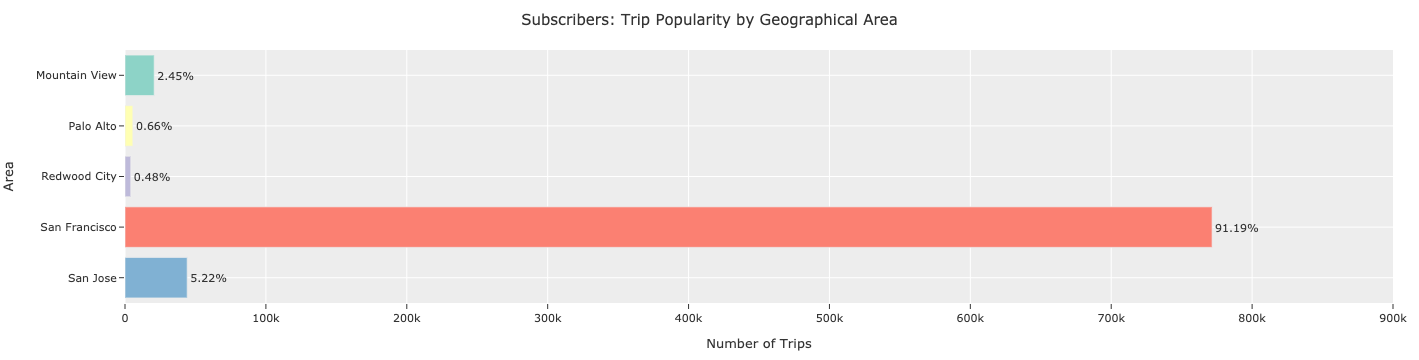

In [12]:
client = bigquery.Client()
sql = """
SELECT 
  subscriber_type,
  start_landmark,
  COUNT(start_landmark) AS starting_point_count,
  CONCAT(
    CAST(
      ROUND(
        COUNT(start_landmark) / SUM(COUNT(start_landmark)) 
        OVER (PARTITION BY subscriber_type) * 100,
        2)
    AS STRING), 
  '%') AS pct
FROM 
  `fluted-bee-273018.w205_proj_1.trips_plus_landmark`
WHERE
  start_landmark = end_landmark
GROUP BY
  subscriber_type,
  start_landmark
ORDER BY
  subscriber_type,
  start_landmark
"""
df = client.query(sql).to_dataframe()

# plot bar charts
# non-subscribers
df_customers = df.loc[df.subscriber_type == 'Customer', :]
fig1 = px.bar(df_customers, 
              y='start_landmark', 
              x='starting_point_count', 
              text='pct',
              orientation='h', 
              color='start_landmark',
              color_discrete_sequence=px.colors.qualitative.Set3,
              width=800, height=350)
fig1.update_traces(textposition='outside')
fig1.update_layout(
    title="Non-subscribers: Trip Popularity by Geographical Area",
    xaxis_title="Number of Trips",
    yaxis_title="Area",
    font=dict(size=11),
    showlegend=False,
    template='ggplot2',
    margin=dict(l=50, r=50, t=50, b=50))
fig1.update_xaxes(range=[0, 140000])
fig1.show()

# subscribers
df_customers = df.loc[df.subscriber_type == 'Subscriber', :]
fig2 = px.bar(df_customers, 
              y='start_landmark', 
              x='starting_point_count', 
              text='pct',
              orientation='h', 
              color='start_landmark',
              color_discrete_sequence=px.colors.qualitative.Set3,
              width=800, height=350)
fig2.update_traces(textposition='outside')
fig2.update_layout(
    title="Subscribers: Trip Popularity by Geographical Area",
    xaxis_title="Number of Trips",
    yaxis_title="Area",
    font=dict(size=11),
    template='ggplot2',
    showlegend=False,
    margin=dict(l=20, r=20, t=50, b=20))
fig2.update_xaxes(range=[0, 900000])
fig2.show()

##### Trip Durations
The table shows that the two customer groups are likely using Bay Wheels' bikes for different purposes. The longer duration from non-subscribers indicate that bikes are probably used for recreation while the shorter duration from subscribers indicates that commuters are focusing on getting from point A to point B as quickly as possible. 

In [4]:
client = bigquery.Client()
sql = """
SELECT
  subscriber_type,
  landmark,
  ANY_VALUE(median_duration_minute) AS median_duration_minute
FROM (
  SELECT 
    subscriber_type,
    start_landmark AS landmark,
    PERCENTILE_CONT(ROUND(duration_sec/60, 2), 0.5) 
    OVER(PARTITION BY subscriber_type, start_landmark) AS median_duration_minute
  FROM 
    `fluted-bee-273018.w205_proj_1.trips_plus_landmark`
  WHERE
    start_landmark = end_landmark AND
    start_landmark = 'San Francisco'
)
GROUP BY
  subscriber_type, landmark
ORDER BY
  subscriber_type, landmark
"""
df = client.query(sql).to_dataframe()
print('Median Duration by Subscriber Type:')
df.rename(columns={'subscriber_type': 'Subscriber Type',
                       'landmark': 'Landmark',
                       'median_duration_minute': 'Median Duration (Minute)'}, inplace=True)
display(df.style.hide_index())

Median Duration by Subscriber Type:


Subscriber Type,Landmark,Median Duration (Minute)
Non-Subscriber,San Francisco,18.28
Subscriber,San Francisco,8.18


##### Station Popularity Map
The map shows that non-subscribers use bikes for different activities at different locations than subscribers do. Note that the size of the circle indicates the number of trips starting from the station.

Top Starting Stations for Subscribers vs. Non-Subscribers:
Note that the size of the circle indicate the volume of trips.
Also note that the chosen map style highlights the ferry routes and major highways.


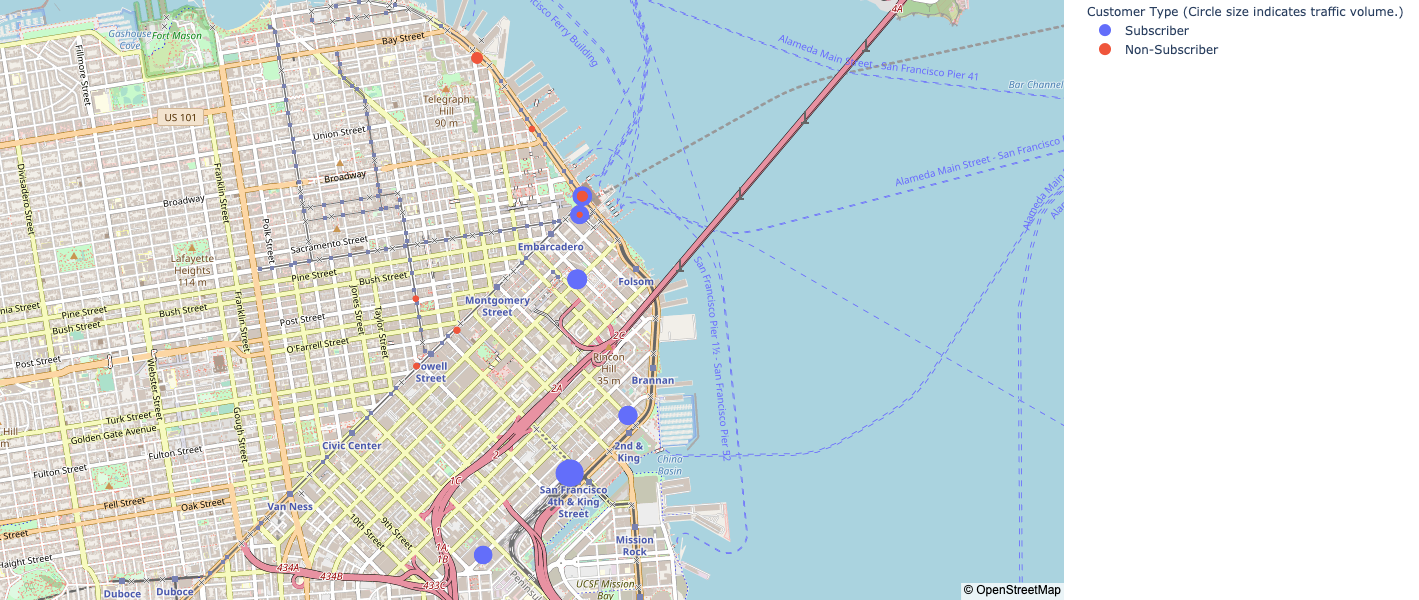


Top Starting Stations by Number of Trips:


Subscriber Type,Starting Station Name,Popularty Rank (by # of Trips)
Subscriber,San Francisco Caltrain (Townsend at 4th),1
Subscriber,San Francisco Caltrain 2 (330 Townsend),2
Subscriber,Temporary Transbay Terminal (Howard at Beale),3
Subscriber,Harry Bridges Plaza (Ferry Building),4
Subscriber,2nd at Townsend,5
Subscriber,Steuart at Market,6
Subscriber,Townsend at 7th,7
Non-Subscriber,Embarcadero at Sansome,1
Non-Subscriber,Harry Bridges Plaza (Ferry Building),2
Non-Subscriber,Market at 4th,3


In [5]:
# query data
client = bigquery.Client()
sql = """
WITH t AS (
  SELECT 
    subscriber_type,
    start_station_name,
    ANY_VALUE(start_station_latitude) AS station_latitude,
    ANY_VALUE(start_station_longitude) AS station_longitude,
    COUNT(start_station_name) AS starting_point_count,
    ROW_NUMBER() OVER (PARTITION BY subscriber_type ORDER BY COUNT(start_station_name) DESC) AS rank
  FROM 
    `fluted-bee-273018.w205_proj_1.trips_plus_landmark`
  WHERE
    start_landmark = end_landmark AND
    start_landmark = "San Francisco"
  GROUP BY
    subscriber_type,
    start_station_name
  ORDER BY
    subscriber_type DESC,
    rank
)
SELECT * FROM t
WHERE
  rank <= 7
"""
df_map = client.query(sql).to_dataframe()

ZOOM = 13
MARK_SIZE = 20
W = 1000
H = 600

# add marker size
df_map.loc[df_map.subscriber_type == 'Subscriber', 'size'] = 12
df_map.loc[df_map.subscriber_type == 'Customer', 'size'] = 5

# map plot
# outdoors, dark, streets, light
fig = px.scatter_mapbox(df_map, 
                        lat='station_latitude', 
                        lon='station_longitude',
                        hover_name='start_station_name', 
                        hover_data=['start_station_name'], 
                        size='starting_point_count',
                        color='subscriber_type',
                        labels={'subscriber_type': 'Customer Type (Circle size indicates traffic volume.)   '},
                        size_max=MARK_SIZE,
                        opacity=1,
                        zoom=ZOOM, 
                        width=W, 
                        height=H)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
print('Top Starting Stations for Subscribers vs. Non-Subscribers:')
print('Note that the size of the circle indicate the volume of trips.')
print('Also note that the chosen map style highlights the ferry routes and major highways.')
fig.show()

df_map.rename(columns={'subscriber_type': 'Subscriber Type',
                       'start_station_name': 'Starting Station Name',
                       'rank': 'Popularty Rank (by # of Trips)'}, inplace=True)
df_map = df_map.loc[:, ['Subscriber Type',
                        'Starting Station Name',
                        'Popularty Rank (by # of Trips)']]
print('\nTop Starting Stations by Number of Trips:')
display(df_map.style.hide_index())

##### Non-Subscriber Trip Duration Breakdown
Note that top 10% of the trips are over 2 hours while the median is only 18 minutes. We should be able to encourage a longer ridership!

In [6]:
# query data
client = bigquery.Client()
sql = """
SELECT 
  trip_id,
  subscriber_type,
  ROUND(duration_sec/60, 2) AS duration_min
FROM 
  `fluted-bee-273018.w205_proj_1.trips_plus_landmark`
WHERE
  start_landmark = end_landmark AND
  start_landmark = 'San Francisco' AND
  subscriber_type = 'Customer'
ORDER BY
  duration_min ASC
"""
df = client.query(sql).to_dataframe()

# prep table rendering
duration = pd.DataFrame(df.loc[:, "duration_min"])
pct_range = np.arange(10, 100, 10) / 100
duration = duration.quantile(pct_range)
duration.index = (duration.index * 100).astype('int')
duration = duration.reset_index()
duration.rename(columns={'duration_min': 'Trip Duration (Min)',
                          'index': 'Percentile'}, inplace=True)

# render percentile duration table
print('Non-subscriber Trip Duration Percentiles:')
pd.set_option("display.precision", 2)
display(duration.style.hide_index())

Non-subscriber Trip Duration Percentiles:


Percentile,Trip Duration (Min)
10,7.20
20,9.70
30,12.15
40,14.93
50,18.28
60,22.62
70,29.00
80,49.97
90,126.12


### Recommendation II: Create New Pricing Models for Specific Routes and Low-Traffic Hours/Months
#### Promotion Design
- **Personalized, Route-Specific Subscription for Routine Commuters:** 
    - Target Audience: 
        - Daily commuters who repeats the same routes on a daily basis.
    - Strategy: 
        - Offer a special low-price subscription model for commuters who choose to bike only between two or a few specific stations.
    - Operational Details:
        - Many commuters bike between two or a few specific stations on a daily basis. To attract new customers who follow the same daily routines, we can offer a low-price subscription model if they opt to bike only between a limited number of pre-selected stations(e.g. between the ferry terminal and Townsend station).
        - This promotion provides additional incentives for routine commuters to subscribe while providing Bay Wheels a more prise usage forecast for inventory management. 
        - Note: Routine subscribers can pay extra if they ever need to bike outside of their pre-selected routes.
- **Special Rates for Low-Traffic Hours/Months:**
    - Target Audience: 
        - Commuters who would bike during low-traffic hours or low-season months. 
    - Strategy: 
        - Offer a special pricing/subscription model for commuters who choose to bike only during low-traffic hours (i.e. 10am-3pm and 7pm-6am) and low-season months (i.e. winter months from November to February).
    - Operational Details:
        - The goal is to maximize our bike usage rate during Bay Wheels' "down time."
        - Customers can enjoy a lower hourly rate if they start and end their trips during the low-traffic hours.
        - Winter deal! Instead of committing to an annual membership, new customers can now "try out" the Bay Wheels experience for an affordable price for the four months between November and February.
        
#### Justifications
An analysis on route popularity shows that a large number of trips repeat twice a day in reverse direction. For example, the number one most popular route in the morning is from "Harry Bridges Plaza (Ferry Building)" to "2nd at Townsend." The most popular route in the afternoon is the same route in reserve order, from from "Harry Bridges Plaza (Ferry Building)" to "2nd at Townsend." Let's take advantage of these routines and offer new customers a personalized, route-specific subscriptions.  

Data show that bike usage peaks at 7am-10am and 4pm-7pm while the characteristics of the trips (as measured by average trip durations) stay relatively similar (at roughly 10 minutes per trip). We need a strategy to improve the ridership during down time. In addition, usage also drops significantly between November and February in winter. Why don't we take advantage of our idle capacity and offer an one-time 4-month trial subscription for people to try the Bay Wheels experience?

#### Supporting Data

##### Route Popularity Analysis
Note that trips in the morning are largely the same than those in the afternoon (as shown by the maps) although the they are traveled in reverse order (as shown by the table below the three maps). A third map that shows the trips at night (12am-5am) is created to demonstrate how trips can differ by hours. The similarity in reverse order between morning and afternoon is not typical throughout the day. 

Also note that the darkness of the lines on map indicates the trips' popularity. It can be easily observed that even the popularity among the different routes is similar in the morning and afternoon.

Top 100 Trips by Popularity in the Morning (5AM-12PM): 
Note: The darker the line is, the more popular the trip path is.


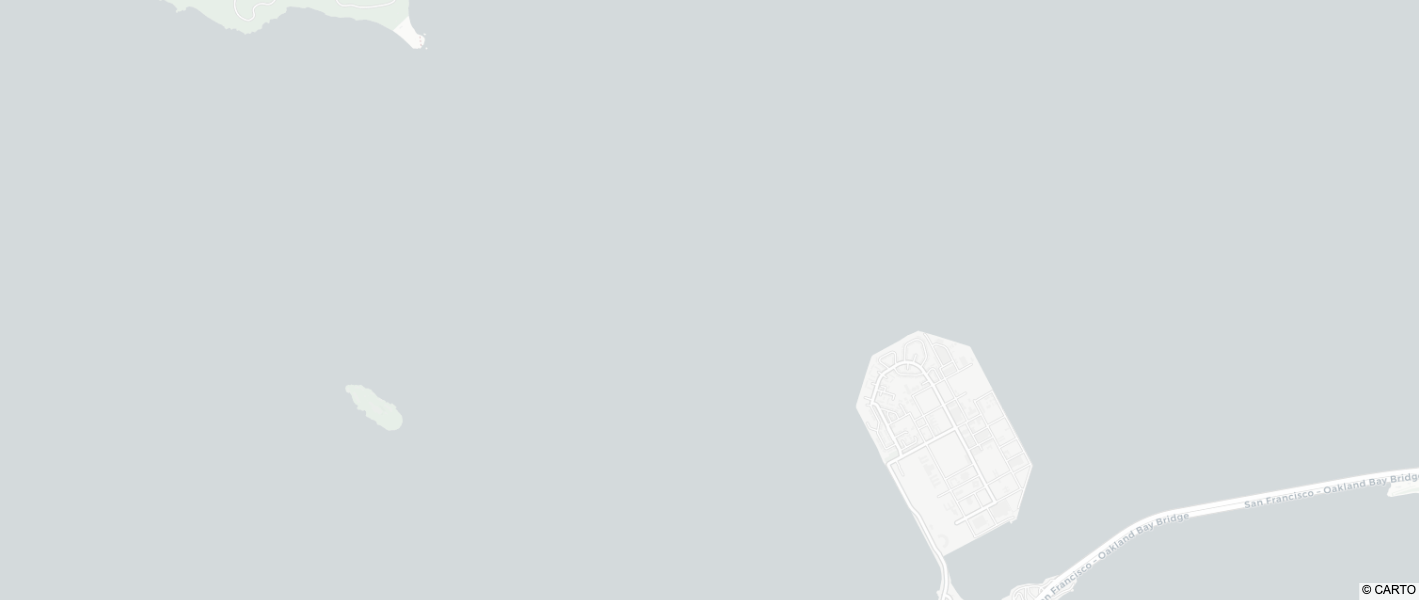


Top 100 Trips by Popularity in the Afternoon (12PM-7PM): 
Note: The darker the line is, the more popular the trip path is.


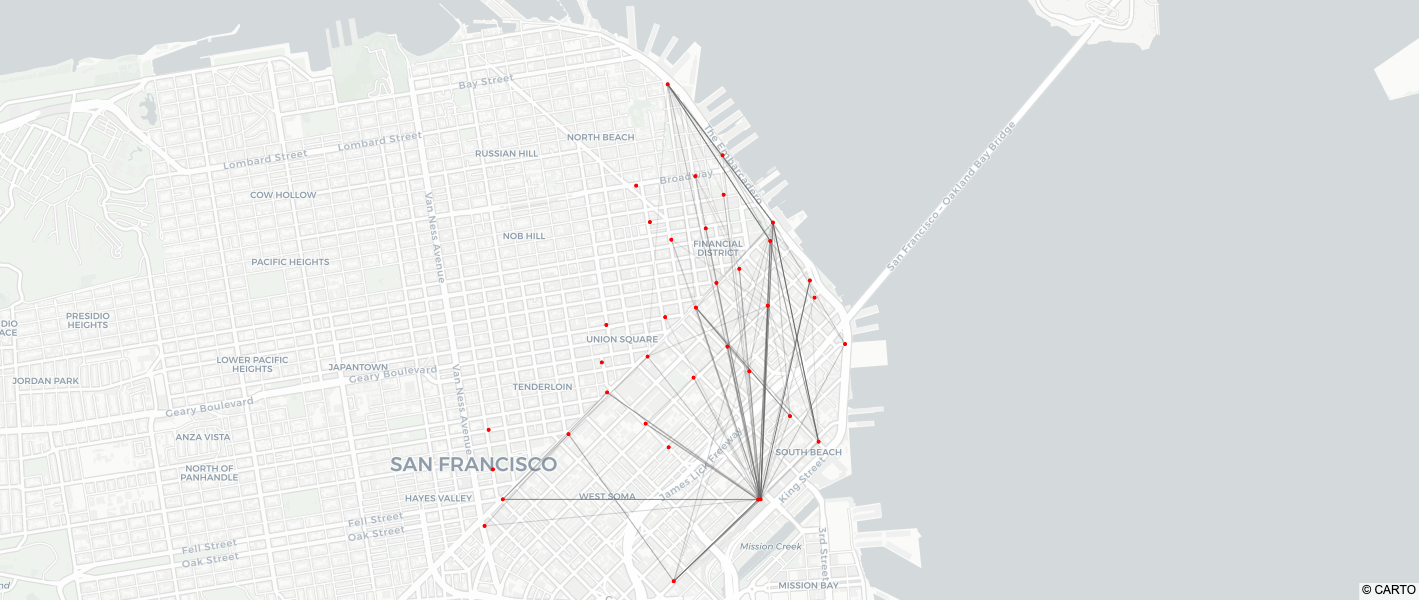


Top 100 Trips by Popularity in the Night (12AM-5AM): 
Note: The darker the line is, the more popular the trip path is.


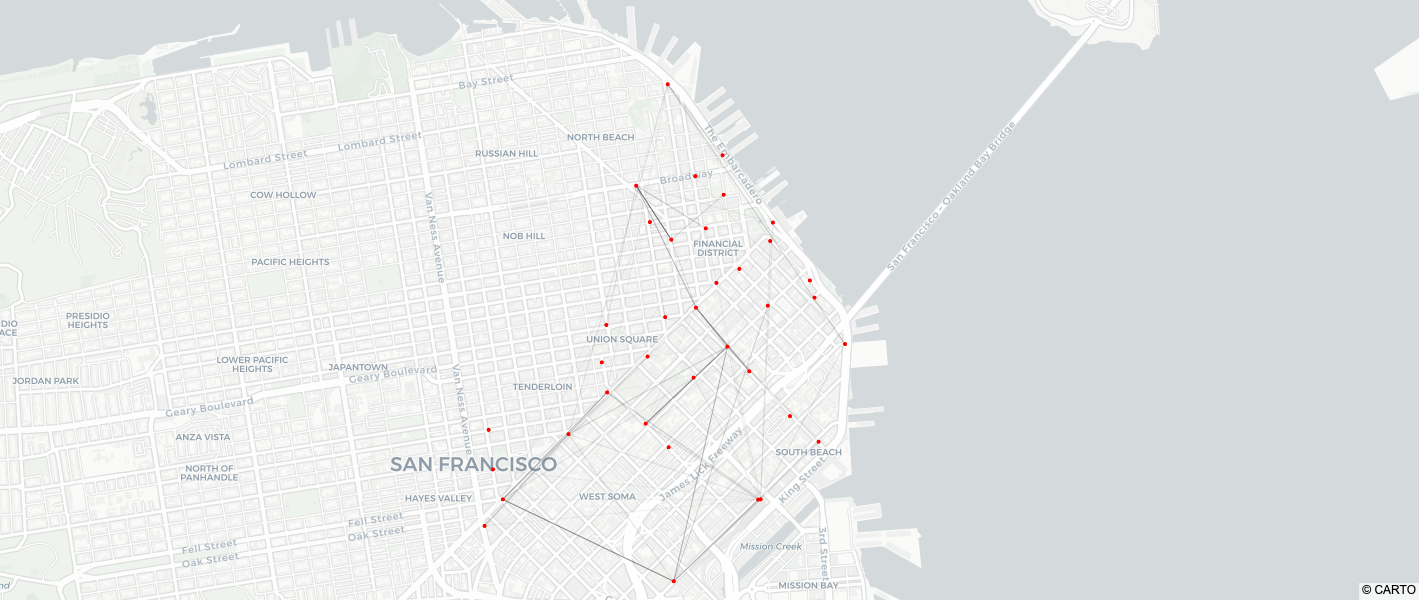


Top 3 Trips by Day Part:


Popularity Rank,Day Part,Start Station,End Station,Trip Count,Avg. Duration (Minute)
1,Morning,Harry Bridges Plaza (Ferry Building),2nd at Townsend,5103,9.75
2,Morning,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,4532,5.02
3,Morning,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),4509,11.68
1,Afternoon,2nd at Townsend,Harry Bridges Plaza (Ferry Building),5878,9.23
2,Afternoon,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),5121,11.41
3,Afternoon,Embarcadero at Sansome,Steuart at Market,4919,8.80
1,Evening,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,1341,5.90
2,Evening,San Francisco Caltrain (Townsend at 4th),2nd at Townsend,793,6.59
3,Evening,Townsend at 7th,San Francisco Caltrain (Townsend at 4th),781,5.99
1,Night,Grant Avenue at Columbus Avenue,Commercial at Montgomery,208,2.01


In [7]:
client = bigquery.Client()
sql = """
SELECT 
  day_part,
  rank AS popularity_rank,
  start_station_name,
  end_station_name,
  start_station_latitude,
  start_station_longitude,
  end_station_latitude,
  end_station_longitude,
  trip_count,
  avg_trip_duration_min AS avg_dur_min
FROM (
  SELECT 
    *,
    ROW_NUMBER() OVER (PARTITION BY day_part ORDER BY trip_count DESC) AS rank
  FROM 
  (
    SELECT
        CASE
            WHEN 5 <= EXTRACT(HOUR FROM start_date) AND EXTRACT(HOUR FROM start_date) < 12 THEN 'Morning'
            WHEN 12 <= EXTRACT(HOUR FROM start_date) AND EXTRACT(HOUR FROM start_date) < 19 THEN 'Afternoon'
            WHEN 19 <= EXTRACT(HOUR FROM start_date) AND EXTRACT(HOUR FROM start_date) < 24 THEN 'Evening'
        ELSE
            'Night'
        END AS day_part,
        start_station_name,
        end_station_name,
        ANY_VALUE(start_station_latitude) AS start_station_latitude,
        ANY_VALUE(start_station_longitude) AS start_station_longitude,
        ANY_VALUE(end_station_latitude) AS end_station_latitude,
        ANY_VALUE(end_station_longitude) AS end_station_longitude, 
        COUNT(*) AS trip_count,
        ROUND((AVG(duration_sec) / 60), 2) AS avg_trip_duration_min
    FROM 
        `fluted-bee-273018.w205_proj_1.trips_plus_landmark`
    WHERE 
      start_landmark='San Francisco' AND
      start_landmark=end_landmark
    GROUP BY
        day_part, start_station_name, end_station_name
    ORDER BY
        day_part='Night', day_part='Evening', day_part='Afternoon', day_part='Morning'
  )
)
ORDER BY
  day_part='Night', day_part='Evening', day_part='Afternoon', day_part='Morning', rank
"""
df = client.query(sql).to_dataframe()

# Only paths (as defined by trips with with the same start/end stations) 
# below or equal to the rank threshold will be drawn. E.g. The path from 
# "Harry Bridges Plaza (Ferry Building)" to "2nd at Townsend" is ranked #1 
# in the morning with a trip count of 5103.
TRIP_RANK_THD = 100 

# style configs
ZOOM = 13
MARK_SIZE = 5
MARK_COLOR = "Red"
MAP_CENTER = [37.7901404,-122.3996471]
MAP_CENTER = {'lat': MAP_CENTER[0], 'lon': MAP_CENTER[1]}
MAP_STYLE = 'carto-positron'
W = 1000
H = 600

def draw_trip_map(df: pd.DataFrame, 
                  day_part: str = 'Morning',
                  time_range: str = None) -> None:
    """Create a map and draw straight lines for each of the trip as defined by 
    its starting and ending points. The more popular the trip is, the darker the line will be.
    
    Args:
        df (pd.DataFrame): Trips data extracted from the dataset.
        day_part (str): 'Morning', 'Afternoon', 'Evening', or 'Night,' as defined by the query.
        time_range (str): String to comment on the time range for the entered day_part.
    """
    # extract unique stations latitudes and longitudes
    df_ss = df.loc[:, ['start_station_name', 'start_station_latitude', 'start_station_longitude']]
    df_es = df.loc[:, ['end_station_name', 'end_station_latitude', 'end_station_longitude']]
    df_ss.rename(columns = {'start_station_name': 'station',
                            'start_station_latitude': 'lat', 
                            'start_station_longitude': 'lon'}, inplace=True)
    df_es.rename(columns = {'end_station_name': 'station',
                            'end_station_latitude': 'lat', 
                            'end_station_longitude': 'lon'}, inplace=True)
    df_stations = pd.concat([df_ss, df_es])
    df_stations.drop_duplicates(['lat', 'lon'], inplace=True)
    df_stations.reset_index(inplace=True)

    # prep trip starting/ending latitude and longitude pairs
    df_day_part = df.loc[(df.day_part == day_part) & 
                         (df.popularity_rank <= TRIP_RANK_THD), :]
    lons = np.empty(3 * len(df_day_part))
    lons[::3] = df_day_part.loc[:, 'start_station_longitude']
    lons[1::3] = df_day_part.loc[:, 'end_station_longitude']
    lons[2::3] = None
    lats = np.empty(3 * len(df_day_part))
    lats[::3] = df_day_part.loc[:, 'start_station_latitude']
    lats[1::3] = df_day_part.loc[:, 'end_station_latitude']
    lats[2::3] = None

    # prep trip line color
    alphas = df_day_part.loc[:, 'trip_count'].reset_index(drop=True)
    alphas = alphas / alphas.max()
    
    # add station location markers to map
    fig = go.Figure()

    # add trip lines
    # lines are added one by one so that the alpha can be adjusted individually
    for i in range(0, lons.shape[0], 3):
        fig.add_trace(
            go.Scattermapbox(
                mode = 'lines',
                lon = lons[i:i+3],
                lat = lats[i:i+3],
                showlegend = False,
                line = dict(
                    width = 1,
                    color = 'rgba(100, 100, 100, {:.2f})'.format(alphas[int(i/3)])
                )))

    # add station markers
    fig.add_trace(
            go.Scattermapbox(mode = "markers",
                             lon = df_stations['lon'],
                             lat = df_stations['lat'],
                             text = df_stations['station'],
                             showlegend = False,
                             marker = dict(size=MARK_SIZE, color=MARK_COLOR)))
    fig.update_layout(
        autosize = False,
        width = W,
        height = H,
        margin = {'l':0,'t':0,'b':0,'r':0},
        mapbox = {
            'center': MAP_CENTER,
            'style': MAP_STYLE,
            'zoom': ZOOM})
    
    print('Top {} Trips by Popularity in the {}: '.format(TRIP_RANK_THD, time_range))
    print('Note: The darker the line is, the more popular the trip path is.')
    fig.show()
    

draw_trip_map(df, 'Morning', 'Morning (5AM-12PM)')
print('')
draw_trip_map(df, 'Afternoon', 'Afternoon (12PM-7PM)')
print('')
draw_trip_map(df, 'Night', 'Night (12AM-5AM)')

# print top 3 using table
df_tbl = df.loc[df.popularity_rank <= 3, ['popularity_rank',
                                          'day_part', 
                                          'start_station_name',
                                          'end_station_name',
                                          'trip_count',
                                          'avg_dur_min']]
df_tbl.rename(columns = {'popularity_rank': 'Popularity Rank',
                         'day_part': 'Day Part', 
                         'start_station_name': 'Start Station',
                         'end_station_name': 'End Station',
                         'trip_count': 'Trip Count',
                         'avg_dur_min': 'Avg. Duration (Minute)'}, inplace=True)
print('\nTop 3 Trips by Day Part:')
pd.set_option("display.precision", 2)
display(df_tbl.style.hide_index())

##### High-Traffic Hour Analysis
Note how bike usage peaks at 7am-10am and 4pm-7pm. Also note that the average trip durations stays relatively the same at around 10 minutes across all hours, indicating that the characteristics of the trips stay similar throughout the day. Bikers don't travel longer just because they are commuting in the morning or afternoon.

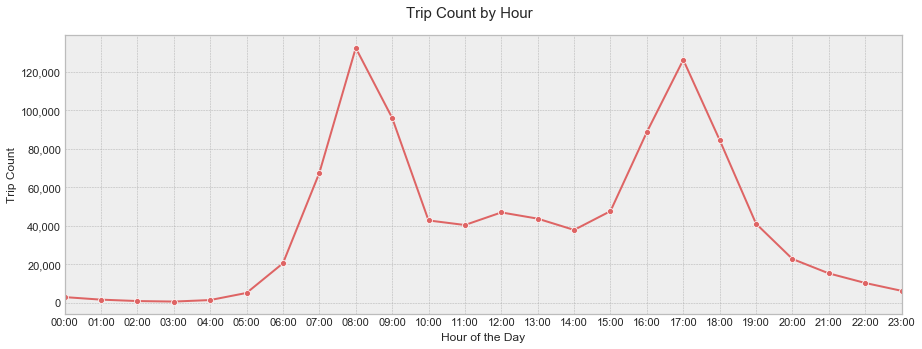

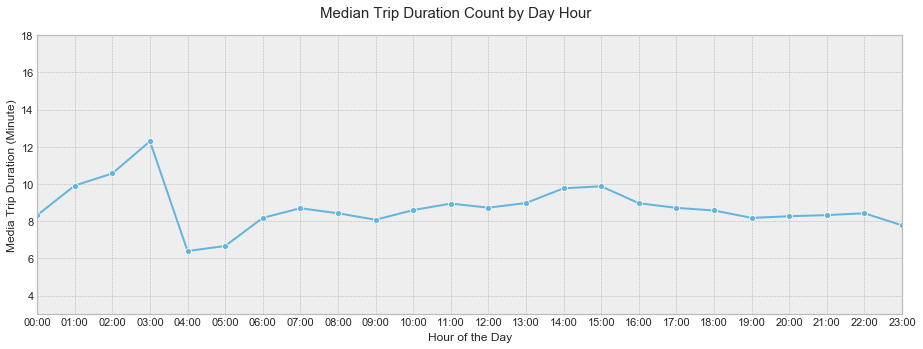

In [8]:
client = bigquery.Client()
sql = """
SELECT
  ANY_VALUE(EXTRACT(HOUR FROM start_date)) AS time_of_day_hour,
  COUNT(trip_id) AS trip_count,
  ANY_VALUE(median_duration_minute) AS median_duration_minute
FROM 
(
  SELECT
    *,
    PERCENTILE_CONT(ROUND(duration_sec/60, 2), 0.5) 
    OVER(PARTITION BY EXTRACT(HOUR FROM start_date)) AS median_duration_minute
  FROM 
    `fluted-bee-273018.w205_proj_1.trips_plus_landmark`
)
GROUP BY
  EXTRACT(HOUR FROM start_date)
ORDER BY
  time_of_day_hour
"""
df = client.query(sql).to_dataframe()

# first plot: trip count by hour
fig, ax = plt.subplots(figsize=(FIG.W, FIG.H))
fig.suptitle("Trip Count by Hour", 
             fontsize=FIG.TITLE_FONT_SIZE)
fig.subplots_adjust(top=FIG.TITLE_LINESPACE)
sns.lineplot(x='time_of_day_hour', y="trip_count",
             ax=ax, data=df,
             markers=True, dashes=False, color="#de6464", marker = "o")
ax.set_xlabel("Hour of the Day", fontsize=FIG.FONT_SIZE)
ax.set_ylabel("Trip Count", fontsize=FIG.FONT_SIZE)
ax.set_xlim([0,23])
ax.xaxis.set_major_formatter(tkr.StrMethodFormatter('{x:02.0f}:00'))
ax.xaxis.set_major_locator(tkr.MultipleLocator(1))
ax.yaxis.set_major_formatter(tkr.StrMethodFormatter('{x:,.0f}'))

# second plot: median trip duration by hour
fig, ax = plt.subplots(figsize=(FIG.W+0.5, FIG.H))
fig.suptitle("Median Trip Duration Count by Day Hour", 
             fontsize=FIG.TITLE_FONT_SIZE)
fig.subplots_adjust(top=FIG.TITLE_LINESPACE)
sns.lineplot(x='time_of_day_hour', y="median_duration_minute",
             ax=ax, data=df,
             markers=True, dashes=False, color="#64b5de", marker = "o")
ax.set_xlabel("Hour of the Day", fontsize=FIG.FONT_SIZE)
ax.set_ylabel("Media Trip Duration (Minute)", fontsize=FIG.FONT_SIZE)
ax.set_xlim([0,23])
ax.set_ylim([3,18])
ax.xaxis.set_major_formatter(tkr.StrMethodFormatter('{x:02.0f}:00'))
ax.xaxis.set_major_locator(tkr.MultipleLocator(1))

pass

##### Seasonality Analysis
Note how the number of trips drop dramatically in winter between November and February. Let's turn the low season into a playground for people who want to try out Bay Wheels at a low low price!  

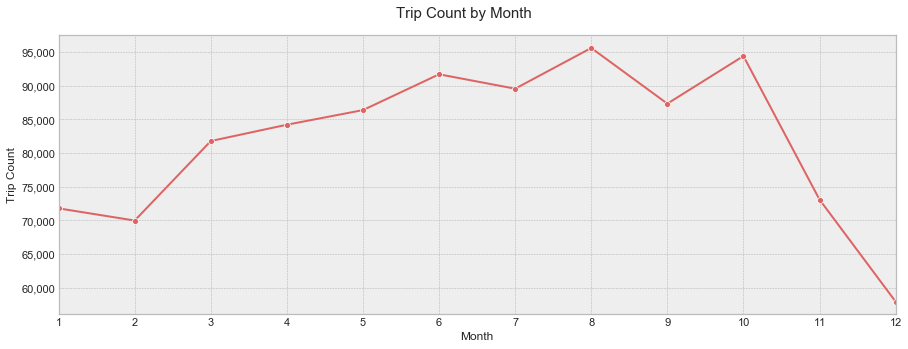

In [9]:
client = bigquery.Client()
sql = """
SELECT
  ANY_VALUE(EXTRACT(MONTH FROM start_date)) AS month,
  COUNT(trip_id) AS trip_count
FROM 
  `fluted-bee-273018.w205_proj_1.trips_plus_landmark`
GROUP BY
  EXTRACT(MONTH FROM start_date)
ORDER BY
  month
"""
df = client.query(sql).to_dataframe()

# plot: trip count by month
fig, ax = plt.subplots(figsize=(FIG.W, FIG.H))
fig.suptitle("Trip Count by Month", 
             fontsize=FIG.TITLE_FONT_SIZE)
fig.subplots_adjust(top=FIG.TITLE_LINESPACE)
sns.lineplot(x='month', y="trip_count",
             ax=ax, data=df,
             markers=True, dashes=False, color="#de6464", marker = "o")
ax.set_xlabel("Month", fontsize=FIG.FONT_SIZE)
ax.set_ylabel("Trip Count", fontsize=FIG.FONT_SIZE)
ax.set_xlim([1,12])
ax.xaxis.set_major_formatter(tkr.StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_major_locator(tkr.MultipleLocator(1))
ax.yaxis.set_major_formatter(tkr.StrMethodFormatter('{x:,.0f}'))

pass

### Recommendation III: Promote Great Brand Stories With Inter-Area Bikers
#### Promotion Design
- Target Audience: 
    - Bikers who choose to travel between two different geographical areas using bikes
- Strategy: 
    - This is a great opportunity to drive brand awareness, as explained by the justifications below. We should start encouraging customers to share their inter-area bike experience by offering rewards for sharing!
- Operational Details:
    - Non-subscribers are having a lot of fun while subscribers are living a healthy lifestyle by traveling between areas using Bay Wheels' bikes. Let's encourage them to share their stories to drive our brand awareness.
    - Sample Promotion: Share your bike experience on Facebook, Instagram, or Twitter for a chance to win two free annual memberships, one for you and the other for your friend or loved one! 
    
#### Justifications
A rather surprising finding is that there are people who travel between geographical areas (e.g. between Palo Alto and Mountain View) using Bay Wheels' bikes. A even more unexpected finding is that there is an almost perfectly even split on these inter-area bikers between subscribers and non-subscribers. Again, the two groups exhibit completely different behaviors: Average trip duration for non-subscribers is roughly 3 hours, which is a strong contrast to the average trip duration of 0.63 hours for subscribers. That is 5 times difference in trip duration between the two customer groups!

According to [Wikipedia](https://tinyurl.com/yaao7bu4), the average casual biking speed is 10-15 mph. The distance between Palo Alto and Mountain View is roughly 7 miles, and a trip duration of 0.63 hours (average speed of subscribers) translates to roughly 11 mph, right about the normal average bike speed. And yet, it takes non-subscribers 5 times longer than the average casual speed to complete the 7 miles of trip. Data clearly show that non-subscribers are taking their time to enjoy their biking experience with Bay Wheels.

While inter-area bikers only contribute a very small number of the ridership as of today, we do believe that there is a potential to explore this untapped market. In addition, creating special deals targeting at inter-area bikers present a great opportunity for Bay Wheels to drive its brand awareness. These people are trusting Bay Wheels' bikes for longer trips, living a healthier lifestyle, and (for non-subscribers) are having a lot of fun with the experience. This is our chance to build some word-of-mouth with great brand stories!

#### Supporting Data
##### Inter-Area Trips
It is rather unexpected to learn that there are people who actually travel between areas using Bay Wheels' bikes. Note that the average trip duration reasonably falls between 0.5 to 1.5 hours, showing that these trips are unlikely to be a result of stolen bikes or system errors. These are real people traveling long distance using Bay Wheels' bikes!

In [10]:
# query data
client = bigquery.Client()
sql = """
SELECT
  *
FROM (
  SELECT
    start_landmark,
    end_landmark,
    COUNT(trip_id) AS trip_count,
    ROUND(AVG(duration_sec/60/60), 2) AS trip_duration_hour
  FROM 
    `fluted-bee-273018.w205_proj_1.trips_plus_landmark`
  WHERE
    start_landmark != end_landmark
  GROUP BY
    start_landmark,
    end_landmark
  ORDER BY
    trip_count DESC
)
WHERE
  trip_count >= 100
"""
df = client.query(sql).to_dataframe()

# prep table rendering
df.rename(columns={'start_landmark': 'Starting Area',
                   'end_landmark': 'Ending Area',
                   'trip_count': 'Trip Count',
                   'trip_duration_hour': 'Avg Trip Duration'}, inplace=True)

# render percentile duration table
print('Inter-Area Trips:')
display(df.style.hide_index())

Inter-Area Trips:


Starting Area,Ending Area,Trip Count,Avg Trip Duration
Palo Alto,Mountain View,530,1.26
Mountain View,Palo Alto,490,1.53
Redwood City,Palo Alto,191,1.02
Palo Alto,Redwood City,117,0.51


##### Inter-Area Trips by Customer Type
A even more surprising finding is the 50-50 split between subscribers and non-subscribers. In addition, judging by the difference in average trip duration, the two customer groups are using the Bay Wheels' bikes for different purposes. Non-Subscribers are having fun with our bikes while subscribers are commuting and trying to live a healthier lifestyle.

In [11]:
# query data
client = bigquery.Client()
sql = """
SELECT
  *
FROM (
  SELECT
    subscriber_type,
    COUNT(trip_id) AS trip_count,
    ROUND(AVG(duration_sec/60/60), 2) AS trip_duration_hour
  FROM 
    `fluted-bee-273018.w205_proj_1.trips_plus_landmark`
  WHERE
    start_landmark != end_landmark
  GROUP BY
    subscriber_type
  ORDER BY
    trip_count DESC
)
WHERE
  trip_count >= 100
"""
df = client.query(sql).to_dataframe()

# prep table rendering
df.rename(columns={'subscriber_type': 'Subscriber Type',
                   'trip_count': 'Trip Count',
                   'trip_duration_hour': 'Avg Trip Duration'}, inplace=True)

# render percentile duration table
print('Inter-Area Trips by Customer Type:')
display(df.style.hide_index())

Inter-Area Trips by Customer Type:


Subscriber Type,Trip Count,Avg Trip Duration
Subscriber,734,0.63
Customer,714,3.01


## Appendix
### Temporary Tables

**Table: util_rate_by_station**
```sql
WITH
  -- metrics for starting points
  start_station AS (
  SELECT
    start_station_id AS id, 
    start_station_name AS station_name,
    COUNT(*) AS start_point_count, 
    MIN(DATE(start_date)) AS first_trip_date
  FROM
    bigquery-public-data.san_francisco.bikeshare_trips
  GROUP BY
    start_station_id, start_station_name
  ORDER BY
    start_station_id ),

  -- metrics for ending points
  end_station AS (
  SELECT
    end_station_id AS id,
    COUNT(*) AS end_point_count,
    MAX(DATE(end_date)) AS last_trip_date
  FROM
    bigquery-public-data.san_francisco.bikeshare_trips
  GROUP BY
    end_station_id
  ORDER BY
    end_station_id )

-- consolidate metrics from start_station & end_station tables
-- calculate the util rate for each station
SELECT
  s.id AS station_id, 
  s.station_name AS station_name, 
  l.landmark,
  l.latitude,
  l.longitude,
  s.start_point_count AS count_start, 
  e.end_point_count AS count_end,
  s.first_trip_date AS first_trip_date,
  e.last_trip_date AS last_trip_date, 
  DATE_DIFF(e.last_trip_date, s.first_trip_date, DAY) AS days_in_serrvice,
  ABS(ROUND((s.start_point_count + e.end_point_count) / DATE_DIFF(e.last_trip_date, s.first_trip_date, DAY), 2)) AS util_rate
FROM
  start_station s
  INNER JOIN end_station e ON s.id = e.id
  INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` l ON s.id = l.station_id
ORDER BY
  station_id
```
  
**Table: trips_plus_landmarks**
```sql
-- add landmark data to trip table
SELECT 
  t.trip_id, 
  t.duration_sec, 
  t.start_date, 
  t.start_station_name,
  t.start_station_id,
  ss.landmark AS start_landmark,
  ss.latitude AS start_station_latitude,
  ss.longitude AS start_station_longitude,
  t.end_date,
  t.end_station_name,
  t.end_station_id,
  se.landmark AS end_landmark,
  se.latitude AS end_station_latitude,
  se.longitude AS end_station_longitude,
  t.bike_number,
  t.zip_code,
  t.subscriber_type
FROM
  `bigquery-public-data.san_francisco.bikeshare_trips` t
  LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` ss ON t.start_station_id = ss.station_id 
  LEFT JOIN `bigquery-public-data.san_francisco.bikeshare_stations` se ON t.end_station_id = se.station_id 
```